# Bubble Answer Sheet Grader

### import necessary libraries

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


### read image 

In [34]:
img = cv2.imread("test.jpg")
img_copy = img.copy() # for display purposes
img_copy1 = img.copy() # for display purposes


In [35]:
img.shape

(766, 700, 3)

# do some pre processings 

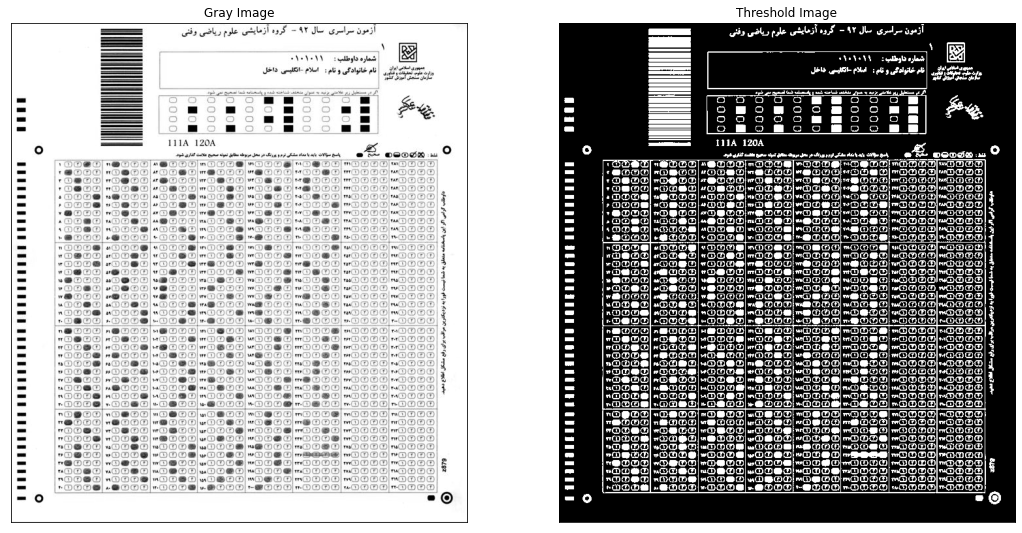

In [36]:
# turn image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
# add blur for denoising
blur = cv2.GaussianBlur(gray,(3,3),0) 

# If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value
ret,thresh_binary_inv = cv2.threshold(gray,220,255,cv2.THRESH_BINARY_INV)

# cv2.imwrite('Gray_Image.jpg',gray)
# cv2.imwrite('BINARY_INV_Image220.jpg',thresh_binary_inv)


plt.figure(figsize=(18,18))
plt.subplot(121),plt.imshow(gray,cmap = 'gray')
plt.title('Gray Image'), plt.xticks([]), plt.yticks([]);
plt.subplot(122),plt.imshow(thresh_binary_inv,cmap = 'gray')
plt.title('Threshold Image'), plt.xticks([]), plt.yticks([]);

plt.show()


### Find the Biggest Contour on the Answer Sheet


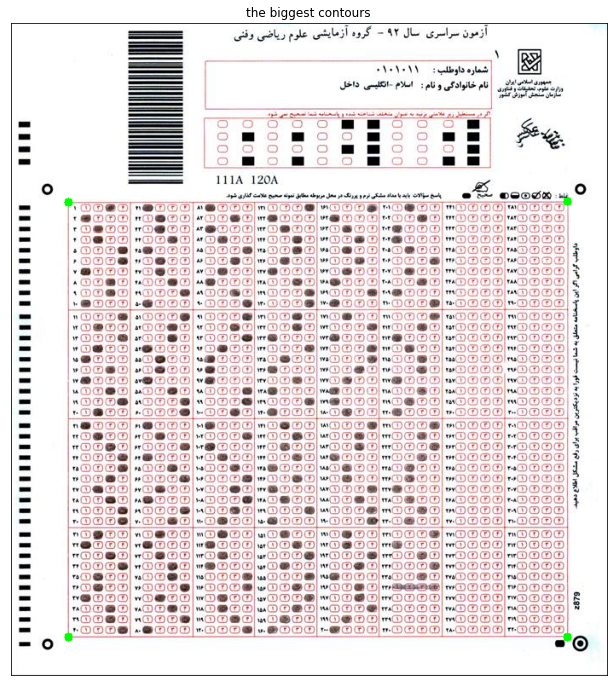

In [37]:
def get_rect_cnts(contours):
    rect_cnts = []
    for cnt in contours:
        # approximate the contour
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        # if the approximated contour is a rectangle ...
        if len(approx) == 4:
            # append it to our list
            rect_cnts.append(approx)
    # sort the contours from biggest to smallest
    rect_cnts = sorted(rect_cnts, key=cv2.contourArea, reverse=True)
    
    return rect_cnts
    
contours, _ = cv2.findContours(thresh_binary_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

rect_cnts = get_rect_cnts(contours)
# contours of the questions
biggest_cnt = rect_cnts[0]


# draw the biggest contours, which are the contour of the questions -1 mean draw 
# cv2.drawContours(img_copy, rect_cnts[:1], -1, (0,255,0), 3)
cv2.drawContours(img_copy, biggest_cnt, -1, (0,255,0), 10)

plt.figure(figsize=(12,12))
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB));
plt.title('the biggest contours'), plt.xticks([]), plt.yticks([]);


### take out the bihhest question box


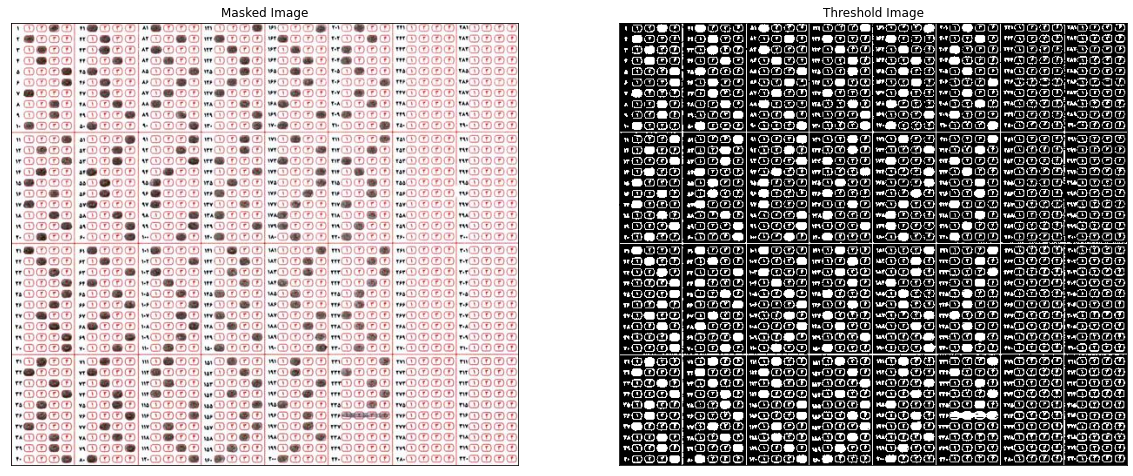

In [38]:
# coordinates of the biggest contour
# I removed 1 pixel from x_W and y_H to make sure we are 
# inside the contour and not take the border of the biggest contour
x, y = biggest_cnt[0][0][0] , biggest_cnt[0][0][1] 
x_W, y_H = biggest_cnt[2][0][0] -1 , biggest_cnt[2][0][1] -1

# create a black image with the same dimension as the document
mask =  np.zeros((img_copy1.shape[0], img_copy1.shape[1]), np.uint8)
# we create a white rectangle in the region of the biggest contour
cv2.rectangle(mask, (x, y), (x_W, y_H), (255,255,255), -1) 
masked = cv2.bitwise_and(img_copy1, img_copy1, mask=mask)


# take only the region of the biggest contour
masked = masked[y:y_H, x:x_W]
gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

# cv2.imwrite('C:/Users/amirr/Desktop/OMR Test/New folder/masked1.jpg',masked)
# cv2.imwrite('C:/Users/amirr/Desktop/OMR Test/New folder/thresh1.jpg',thresh)

plt.figure(figsize=(20,20));
plt.subplot(121),plt.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB))
plt.title('Masked Image'), plt.xticks([]), plt.yticks([]);
plt.subplot(122),plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
plt.title('Threshold Image'), plt.xticks([]), plt.yticks([]);

questions_box_section_img = masked.copy()


### resize image box area 

In [39]:
questions_box_section_img = cv2.resize(questions_box_section_img,(509, 584))

### find all points of rectangles (each box of questions)

In [40]:
def section_identifier(height, width, num_box_col, num_box_row):
    height_section = height / num_box_row
    width_section = width / num_box_col
    x = 0
    y = 0
    section_list = []
    for j in range(0, num_box_col):
        x = j * width_section
        y = 0
        for i in range(0, num_box_row):

            current_coor = [[x, y], [x+width_section, y],
                            [x, y+height_section], [x+width_section, y+height_section]]
            
            section_list.append(current_coor)
            y = (i+1) * height_section

    questions_box_section = np.asarray(section_list, dtype=np.int32)

    return questions_box_section

### get coordinates of each of the boxes

In [41]:
questions_box_section = section_identifier(masked.shape[0], masked.shape[1], 8, 4)


### convert to numpy array 

In [42]:
questions_box_section = np.asarray(questions_box_section, dtype=np.int32)
type(questions_box_section)


numpy.ndarray

### take out the boxes of the questions 

In [43]:
def take_desired_box(box, questions_box_section_img):
    # coordinates of the biggest contour
    # I added 4 pixels to x and y, and removed 4 pixels from x_W and y_H to make 
    # sure we are inside the contour and not take the border of the biggest contour
    x, y = box[0][0]   , box[0][1] 
    x_W, y_H = box[3][0]   , box[3][1] 

    # create a black image with the same dimension as the document
    mask =  np.zeros((questions_box_section_img.shape[0], questions_box_section_img.shape[1]), np.uint8)
    # we create a white rectangle in the region of the biggest contour
    cv2.rectangle(mask, (x, y), (x_W, y_H), (255,255,255), -1) 
    questions_box_section = cv2.bitwise_and(questions_box_section_img, questions_box_section_img, mask=mask)


    # take only the region of the biggest contour
    questions_box_section_new = questions_box_section[y:y_H, x:x_W]
    gray = cv2.cvtColor(questions_box_section_new, cv2.COLOR_BGR2GRAY)
    _, questions_box_section_new = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

    # cv2.imwrite('C:/Users/amirr/Desktop/OMR Test/New folder/maskedbox1.jpg',questions_box_section)
    # cv2.imwrite('C:/Users/amirr/Desktop/OMR Test/New folder/threshbox1.jpg',thresh_box_section)

    # plt.figure(figsize=(12,12));
    # plt.subplot(121),plt.imshow(cv2.cvtColor(questions_box_section, cv2.COLOR_BGR2RGB))
    # plt.title('Masked Image'), plt.xticks([]), plt.yticks([]);
    # plt.subplot(122),plt.imshow(cv2.cvtColor(questions_box_section_new, cv2.COLOR_BGR2RGB))
    # plt.title('Threshold Image'), plt.xticks([]), plt.yticks([]);

    return questions_box_section_new


### take out each of the choices

In [44]:
def splitBoxes(img, num_questions, num_answers):
    rows = np.vsplit(img, num_questions)
    boxes=[]
    for r in rows:
        cols= np.hsplit(r, num_answers)
        for box in cols:
            boxes.append(box)
    return boxes

# boxes1 = splitBoxes(thresh_new1, 10, 4)


### grade the questions

In [45]:
def grade_sheet(boxes, questions=10, num_answers=4):
    countR=0
    countC=0
    # questions = 10
    correct_ans = [0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0 ]
    myPixelVal = np.zeros((questions,num_answers)) # TO STORE THE NON ZERO VALUES OF EACH BOX
    for image in boxes:
        #cv2.imshow(str(countR)+str(countC),image)
        totalPixels = cv2.countNonZero(image)
        myPixelVal[countR][countC]= totalPixels
        # print(myPixelVal[countR][countC])
        countC += 1
        if (countC==num_answers):countC=0;countR +=1

    # FIND THE USER ANSWERS AND PUT THEM IN A LIST
    myIndex=[]
    for x in range (0,questions):
        arr = myPixelVal[x]
        myIndexVal = np.where(arr == np.amax(arr))
        myIndex.append(myIndexVal[0][0])
    #print("USER ANSWERS",myIndex)

    # COMPARE THE VALUES TO FIND THE CORRECT ANSWERS
    grading=[]
    for x in range(0,questions):
        if correct_ans[x] == myIndex[x]:
            grading.append(1)
        else:grading.append(0)
    #print("GRADING",grading)
    score = (sum(grading)/questions)*100 # FINAL GRADE
    #print("SCORE",score)
    return score

### find score of the each question box

In [46]:
each_box_grade = []
for i in range(0, 22):
    # take index i of boxes 
    box_section= take_desired_box(questions_box_section[i], questions_box_section_img)  
    # crop the selected box 
    box_section=box_section[3:123,14:70]
    # take out each of the choices
    box_each_choices = splitBoxes(box_section, 10, 4)
    # grade the each of the questions
    box_score = grade_sheet(box_each_choices, 10, 4)
    # print(box_score)
    each_box_grade.append(box_score)


### total score 

In [49]:
each_box_grade = np.asarray(each_box_grade, dtype=np.int32)
total_score = each_box_grade.sum()/22
print(f'Total score of the answer sheet is {int(total_score)} %')  

Total score of the answer sheet is 34 %
